European Call Option Price: 0.5754
European Put Option Price: 0.5651


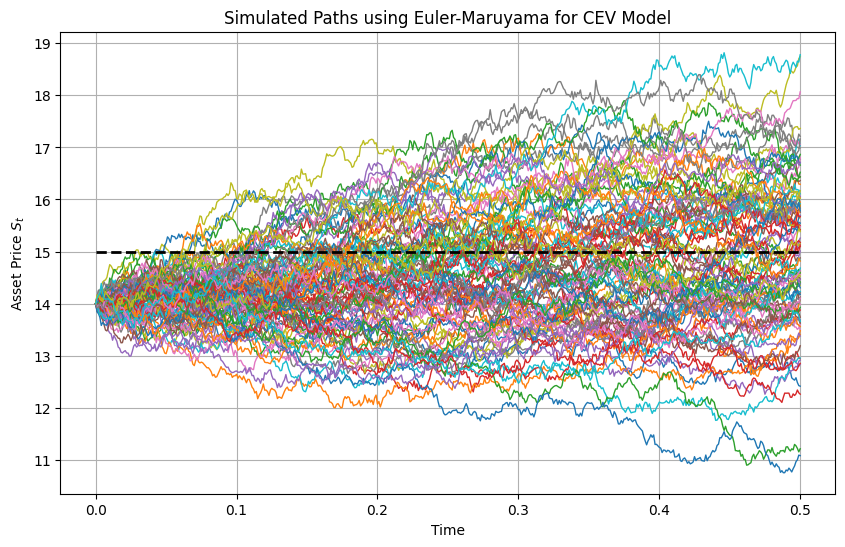

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the CEV model
r = 0.1          # Risk-free rate
sigma = 0.25     # Volatility
gamma = 0.8      # Elasticity parameter (CEV parameter)
S0 = 14          # Initial value of the asset (e.g. stock price)
T = 0.5          # Time horizon
N = 500          # Number of time steps
dt = T / N       # Time step size
n_simulations = [100, 1000, 10000, 100000]  # Number of simulation paths
K = 15           # Strike price of the option

# Generate random Brownian increments
dW = np.random.normal(0, np.sqrt(dt), (n_simulations, N))

# Initialize array to store the simulated paths
S = np.zeros((n_simulations, N + 1))
S[:, 0] = S0

# Euler-Maruyama method to simulate the paths
for i in range(N):
    S[:, i+1] = S[:, i] + r * S[:, i] * dt + sigma * S[:, i]**gamma * dW[:, i]

# Compute the payoff at maturity for each simulation path
payoffs_call = np.maximum(S[:, -1] - K, 0)
payoffs_put = np.maximum(K-S[:, -1], 0)

# Calculate the mean of the payoffs
mean_payoff_call = np.mean(payoffs_call)
mean_payoff_put = np.mean(payoffs_put)

# Calculate the standard deviation of the payoffs
std_payoff_call = np.std(payoffs_call)
std_payoff_put = np.std(payoffs_put)

# Discount the mean payoff to present value
call_option_price = np.exp(-r * T) * mean_payoff_call
put_option_price = np.exp(-r * T) * mean_payoff_put

# Output the call option price
print(f"European Call Option Price: {call_option_price:.4f}")
print(f"European Put Option Price: {put_option_price:.4f}")
# Plotting the simulated paths
plt.figure(figsize=(10, 6))
for j in range(n_simulations):
    plt.plot(np.linspace(0, T, N+1), S[j, :], lw=1)
# Plot the strike price
plt.plot([0, T], [K, K], 'k--', lw=2)
plt.title('Simulated Paths using Euler-Maruyama for CEV Model')
plt.xlabel('Time')
plt.ylabel('Asset Price $S_t$')
plt.grid(True)
plt.show()

In [ ]:
# Compute the payoff at maturity for each simulation path
payoffs = np.maximum(S[:, -1] - K, 0)

# Calculate the mean of the payoffs
mean_payoff = np.mean(payoffs)

# Discount the mean payoff to present value
call_option_price = np.exp(-r * T) * mean_payoff

# Estimate the sample error (standard deviation of the payoff)
std_dev_payoffs = np.std(payoffs)
sample_error = std_dev_payoffs / np.sqrt(n_simulations)

# Output the call option price and the estimated sample error
print(f"European Call Option Price: {call_option_price:.4f}")
print(f"Estimated Sample Error: {sample_error:.4f}")

In [ ]:
# Function to simulate the option price with given time steps (N)
def simulate_option_price(N):
    dt = T / N
    dW = np.random.normal(0, np.sqrt(dt), (n_simulations, N))
    
    # Simulate paths
    S = np.zeros((n_simulations, N + 1))
    S[:, 0] = S0
    for i in range(N):
        S[:, i+1] = S[:, i] + r * S[:, i] * dt + sigma * S[:, i]**gamma * dW[:, i]
    
    # Compute the payoff at maturity
    payoffs = np.maximum(S[:, -1] - K, 0)
    mean_payoff = np.mean(payoffs)
    call_option_price = np.exp(-r * T) * mean_payoff
    
    return call_option_price

# Run simulations with different time steps
N_values = [250, 500, 1000, 2000]
prices = [simulate_option_price(N) for N in N_values]

# Output the prices for different time steps
for N, price in zip(N_values, prices):
    print(f"Option Price with N = {N}: {price:.4f}")
